<a href="https://www.kaggle.com/code/yaaangzhou/ps3e18-version-4-eda-feature-selection?scriptVersionId=135454873" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install flaml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.5/260.5 kB 5.0 MB/s eta 0:00:00


<h1 style="font-family:verdana;"> <center> 🎯PS3 E18: Explore Multi-Label Classification with an Enzyme Substrate Datasets🚀</center> </h1>


# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#1871c9; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #000966">Version 4</p>

***This notebook contains the following: import data, EDA, feature engineering, build baseline models and an ensemble model.***

***The idea for this solution comes mainly from a post in the discussion forum. The authors argue that the task should be performed as two separate tasks, i.e. two different classification predictions.***

***This means that for both tasks features and models need to be selected independently.***


# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#1871c9; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #000966">Imports</p>

In [2]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Statistical Tests
from scipy.stats import f_oneway

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Model Selection
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, classification_report
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC


# Models
import optuna
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from lightgbm import LGBMClassifier, LGBMRegressor
from flaml import AutoML

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Adjusting plot style

rc = {
    "axes.facecolor": "#F8F8F8",
    "figure.facecolor": "#F8F8F8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
mgt = Style.BRIGHT + Fore.MAGENTA
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

In [4]:
test = pd.read_csv('/kaggle/input/playground-series-s3e18/test.csv')
train = pd.read_csv('/kaggle/input/playground-series-s3e18/train.csv')
sample = pd.read_csv('/kaggle/input/playground-series-s3e18/sample_submission.csv')

In [5]:
target = ['EC1','EC2']

train = train.drop(['id', 'EC3', 'EC4', 'EC5', 'EC6'], axis=1)
test = test.drop(['id'], axis=1)

# features category
cat = train.columns[train.nunique() < 10]
cat = cat.drop(target)

# features numerical
num = train.columns[~train.columns.isin(cat)]
num = num.drop(target)

print('The shape of train is: ', train.shape)
print('The shape of test is: ', test.shape)

print('The number of numerical features is: ', len(num))
print('The number of categorical features is: ', len(cat))

The shape of train is:  (14838, 33)
The shape of test is:  (9893, 31)
The number of numerical features is:  29
The number of categorical features is:  2


In [6]:
train.head()

,BertzCT,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3v,Chi4n,EState_VSA1,EState_VSA2,...,PEOE_VSA7,PEOE_VSA8,SMR_VSA10,SMR_VSA5,SlogP_VSA3,VSA_EState9,fr_COO,fr_COO2,EC1,EC2
0,323.390782,9.879918,5.875576,5.875576,4.304757,4.304757,2.754513,1.749203,0.000000,11.938294,...,0.000000,0.000000,17.744066,0.000000,4.794537,35.527357,0,0,1,1
1,273.723798,7.259037,4.441467,5.834958,3.285046,4.485235,2.201375,1.289775,45.135471,0.000000,...,0.000000,0.000000,7.822697,30.705892,13.825658,44.707310,0,0,0,1
2,521.643822,10.911303,8.527859,11.050864,6.665291,9.519706,5.824822,1.770579,15.645394,6.606882,...,53.378235,0.000000,15.645394,73.143616,17.964475,45.660120,0,0,1,1
3,567.431166,12.453343,7.089119,12.833709,6.478023,10.978151,7.914542,3.067181,95.639554,0.000000,...,0.000000,6.420822,15.645394,62.107304,31.961948,87.509997,0,0,1,1
4,112.770735,4.414719,2.866236,2.866236,1.875634,1.875634,1.036450,0.727664,17.980451,12.841643,...,19.386400,0.000000,11.938611,18.883484,9.589074,33.333333,2,2,1,0


In [7]:
train.describe().T\
    .style.bar(subset=['mean'], color=px.colors.qualitative.G10[2])\
    .background_gradient(subset=['std'], cmap='Blues')\
    .background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
BertzCT,14838.000000,515.153604,542.456370,0.000000,149.103601,290.987941,652.652585,4069.959780
Chi1,14838.000000,9.135189,6.819989,0.000000,4.680739,6.485270,11.170477,69.551167
Chi1n,14838.000000,5.854307,4.647064,0.000000,2.844556,4.052701,7.486791,50.174588
Chi1v,14838.000000,6.738497,5.866444,0.000000,2.932842,4.392859,8.527859,53.431954
Chi2n,14838.000000,4.432570,3.760516,0.000000,1.949719,2.970427,5.788793,32.195368
Chi2v,14838.000000,5.253221,4.925065,0.000000,2.034468,3.242775,6.609350,34.579313
Chi3v,14838.000000,3.418749,3.436208,0.000000,1.160763,1.948613,4.502070,22.880836
Chi4n,14838.000000,1.773472,1.865898,0.000000,0.503897,1.073261,2.534281,16.072810
EState_VSA1,14838.000000,29.202823,31.728679,0.000000,5.969305,17.353601,44.876559,363.705954
EState_VSA2,14838.000000,10.435316,13.651843,0.000000,0.000000,6.420822,12.841643,99.936429


***In the original dataset, there were 29 continuous variables and 2 categorical variables. The scale of the data varies greatly, which means we need to scale them before training.***

In [8]:
def summary(df):
    sum = pd.DataFrame(df.dtypes, columns=['dtypes'])
    sum['missing#'] = df.isna().sum().values*100
    sum['missing%'] = (df.isna().sum().values*100)/len(df)
    sum['uniques'] = df.nunique().values
    sum['count'] = df.count().values
    sum['skew'] = df.skew().values
    desc = pd.DataFrame(df.describe().T)
    sum['min'] = desc['min']
    sum['max'] = desc['max']
    sum['mean'] = desc['mean']
    
    return sum

summary(train).style.background_gradient(cmap='Blues')

,dtypes,missing#,missing%,uniques,count,skew,min,max,mean
BertzCT,float64,0,0.000000,2368,14838,1.775677,0.000000,4069.959780,515.153604
Chi1,float64,0,0.000000,1259,14838,1.679368,0.000000,69.551167,9.135189
Chi1n,float64,0,0.000000,3157,14838,1.722855,0.000000,50.174588,5.854307
Chi1v,float64,0,0.000000,3306,14838,1.782578,0.000000,53.431954,6.738497
Chi2n,float64,0,0.000000,3634,14838,1.667144,0.000000,32.195368,4.432570
Chi2v,float64,0,0.000000,3725,14838,1.748260,0.000000,34.579313,5.253221
Chi3v,float64,0,0.000000,3448,14838,1.644531,0.000000,22.880836,3.418749
Chi4n,float64,0,0.000000,2930,14838,1.893930,0.000000,16.072810,1.773472
EState_VSA1,float64,0,0.000000,719,14838,1.426010,0.000000,363.705954,29.202823
EState_VSA2,float64,0,0.000000,445,14838,1.914321,0.000000,99.936429,10.435316


In [9]:
# Cross table betweem EC1 and EC2
pd.crosstab(train['EC1'], train['EC2']).style.background_gradient(cmap='Blues')

EC2,0,1
EC1,,
0,582,4348
1,2401,7507


***There are also no missing values in the data. Some of the data appear to be unevenly distributed, and we will find out later if this is the case.***

# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#1871c9; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #000966">EDA</p>

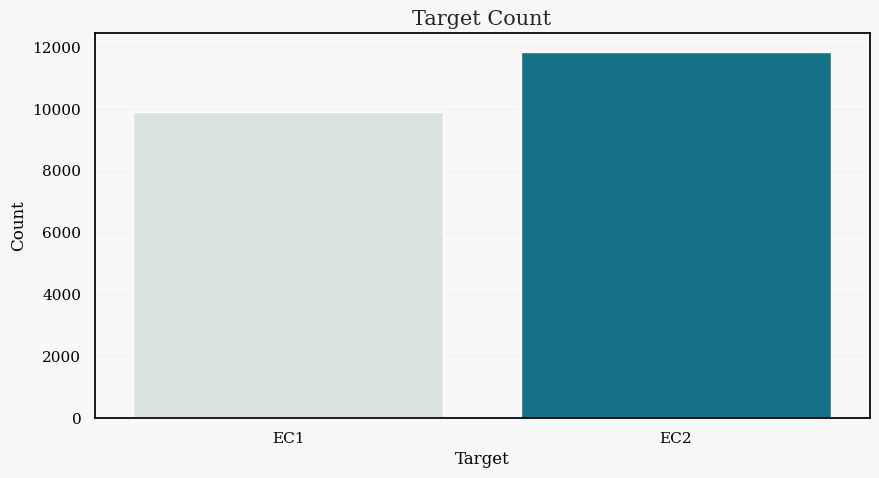

In [10]:
target_count = [train[i].sum() for i in target]
plt.figure(figsize=(10, 5))
sns.barplot(x=target, y=target_count, palette=['#D8E3E2','#037d97'])
plt.title('Target Count', fontsize=15)
plt.xlabel('Target', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

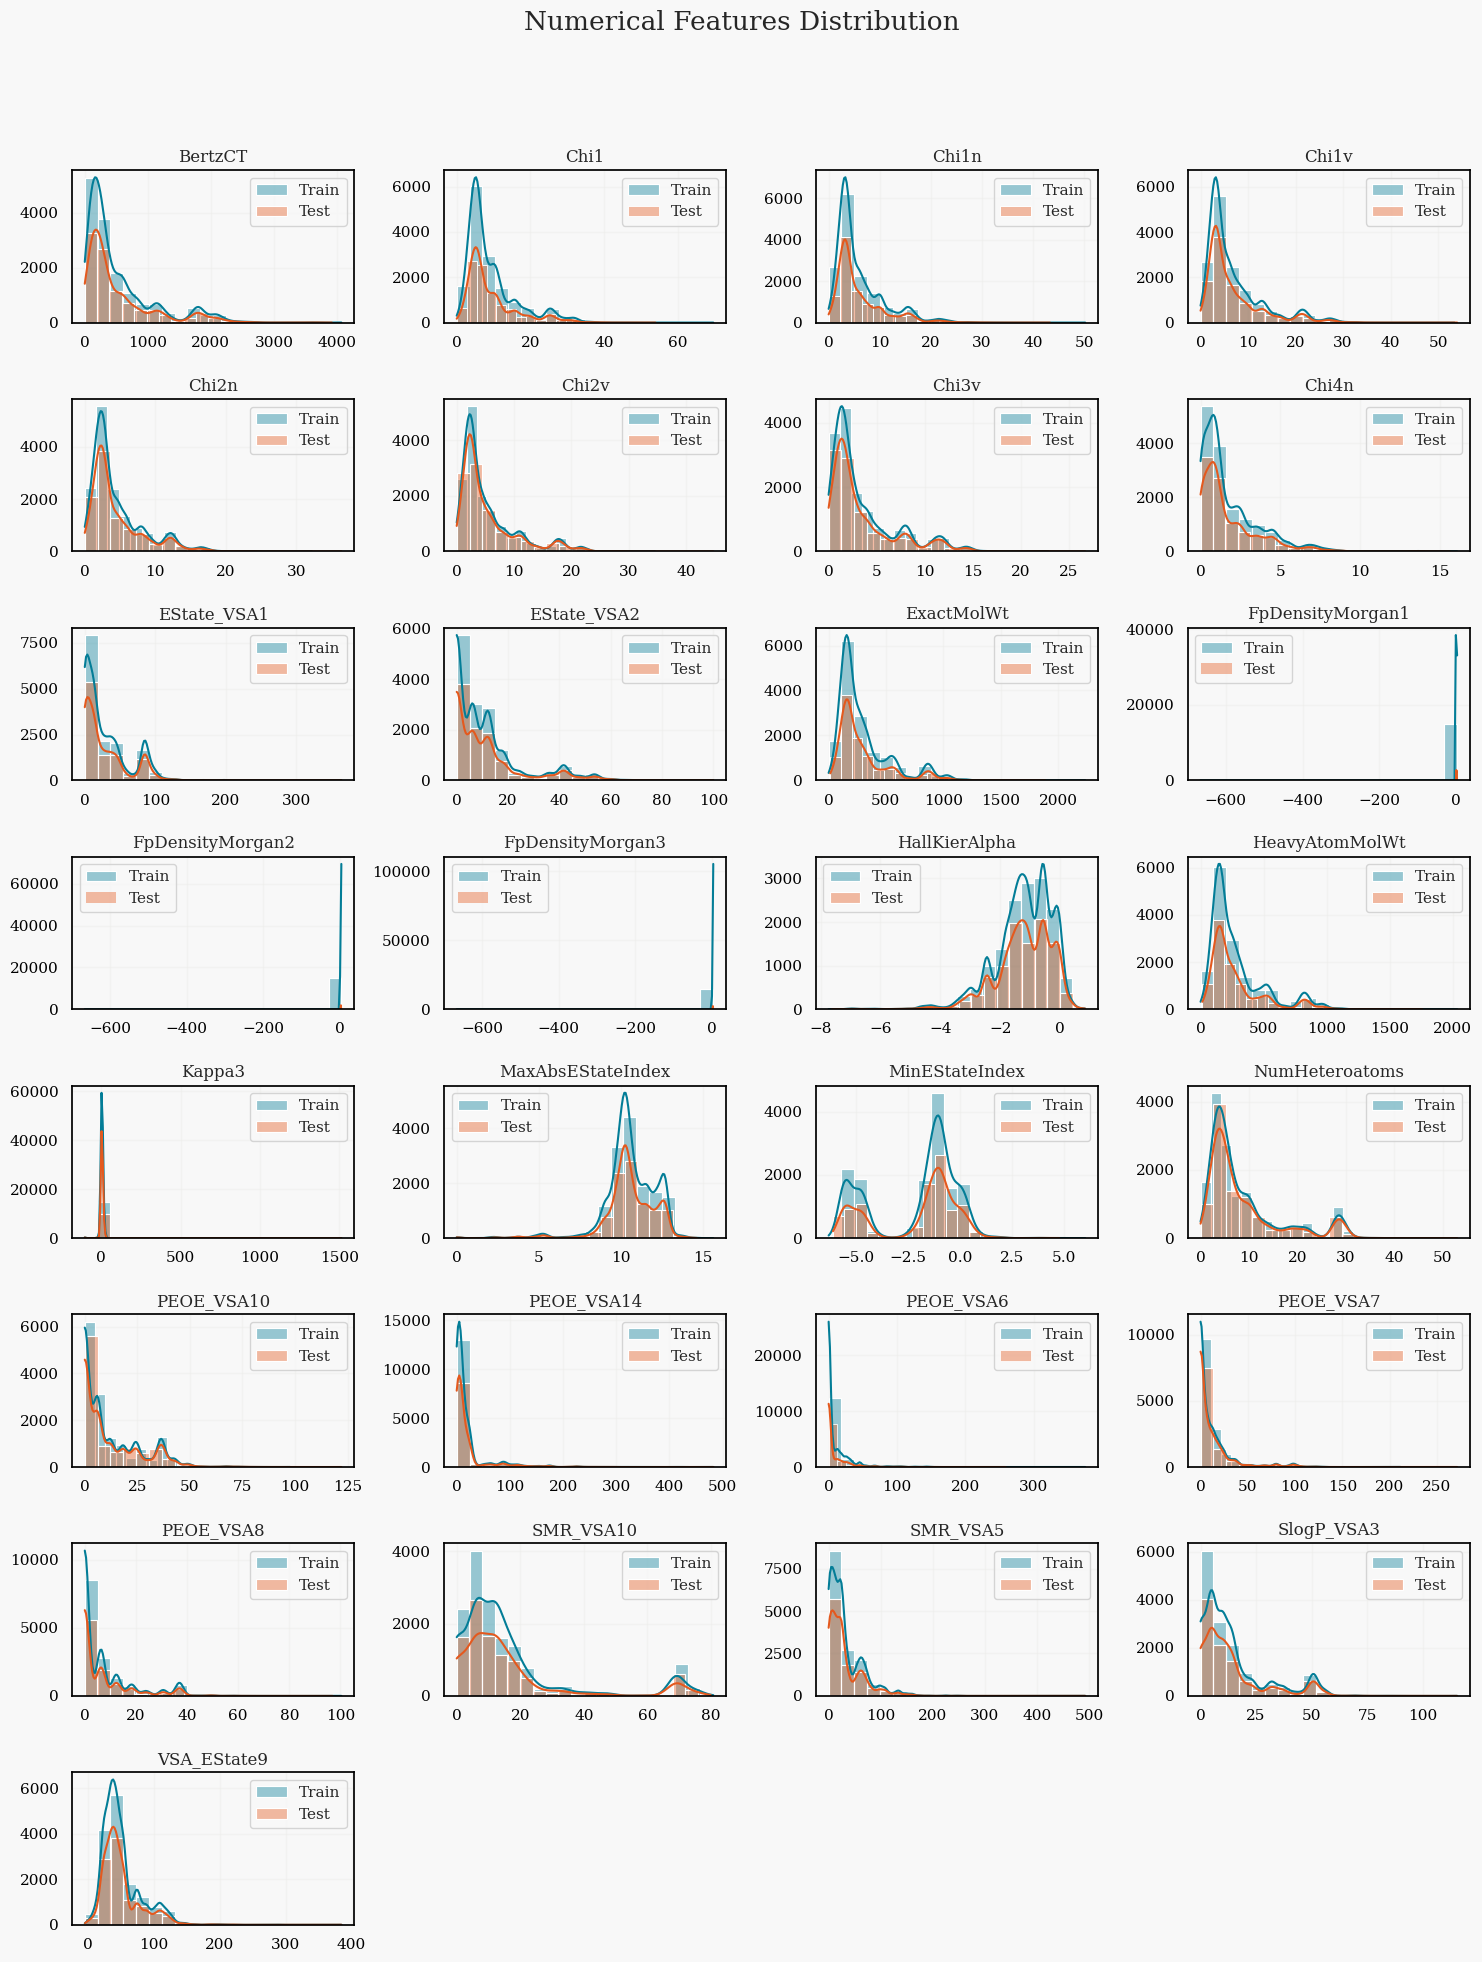

In [11]:
color_palette = palette

fig, axs = plt.subplots(8, 4, figsize=(15,20))
axs = axs.flatten()

for i, col in enumerate(num):
    ax = axs[i]
    sns.histplot(train[col], ax=ax, bins=20, label="Train", color=palette[1], alpha=0.4, kde=True)
    sns.histplot(test[col], ax=ax, bins=20, label="Test", color=palette[2], alpha=0.4, kde=True)

    ax.set_title(col, fontsize=12)
    ax.set_xlabel(None, fontsize=12)  
    ax.set_ylabel(None, fontsize=12)
    ax.legend()

for j in range(len(num), len(axs)):
    fig.delaxes(axs[j])

sns.set_palette(color_palette)
plt.tight_layout()
plt.suptitle('Numerical Features Distribution', fontsize=19)
plt.subplots_adjust(top=0.9, hspace=0.5)
plt.show()

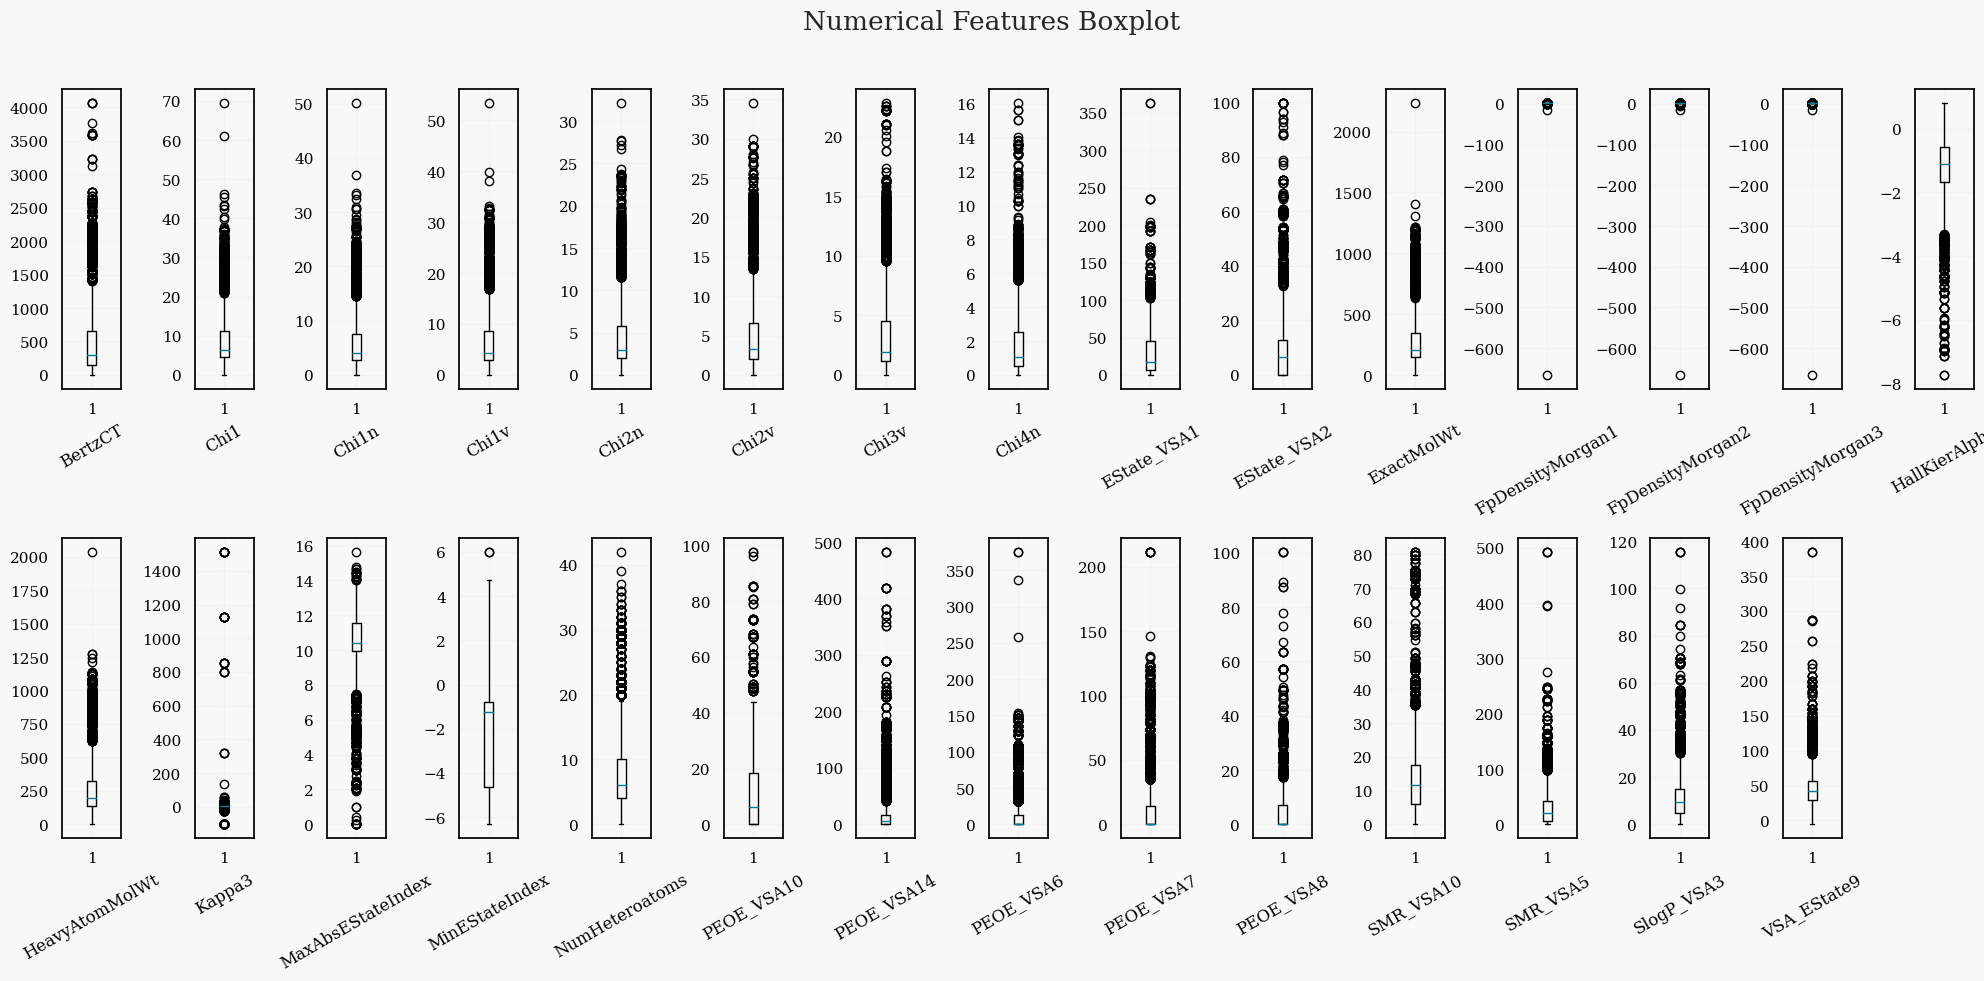

In [12]:
fig, axs = plt.subplots(2, len(num)//2+1, figsize=(20, 10))
axs = axs.flatten()
for i, col in enumerate(num):
    ax = axs[i]
    ax.boxplot(train[col])
    ax.set_xlabel(col, fontsize=12,rotation=30)

for j in range(len(num), len(axs)):
    fig.delaxes(axs[j])
    
plt.tight_layout()
plt.suptitle('Numerical Features Boxplot', fontsize=19)
plt.subplots_adjust(top=0.9, hspace=0.5)
plt.show()

***Key points:***

***1. In terms of distribution, the skewness of some of them is relatively high.***

***2. Most of the features of the same name, their distribution is very similar.***

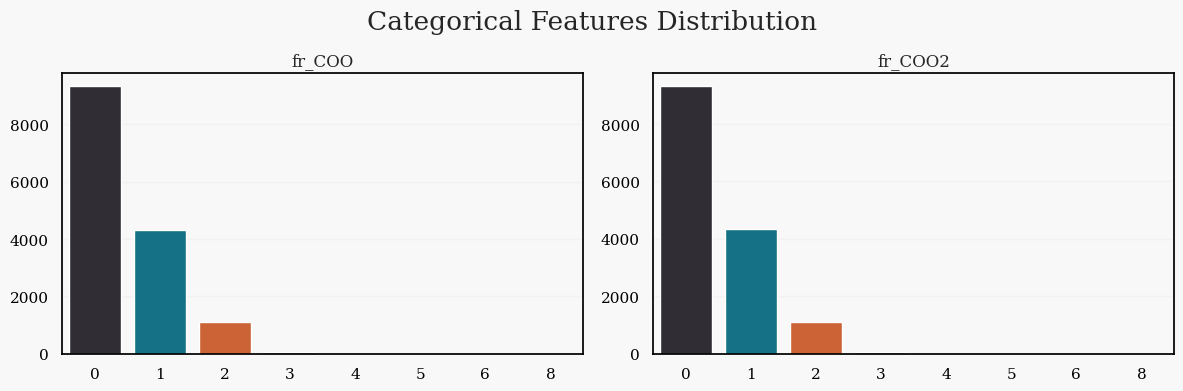

In [13]:
# features category

fig, axs = plt.subplots(2, 2, figsize=(12,8))
axs = axs.flatten()

for i, col in enumerate(cat):
    ax = axs[i]
    sns.countplot(x=col, data=train, ax=ax, palette=palette)
    ax.set_title(col, fontsize=12)
    ax.set_xlabel(None, fontsize=12)  
    ax.set_ylabel(None, fontsize=12)

for j in range(len(cat), len(axs)):
    fig.delaxes(axs[j])

sns.set_palette(color_palette)
plt.tight_layout()
plt.suptitle('Categorical Features Distribution', fontsize=19)
plt.subplots_adjust(top=0.9, hspace=0.5)
plt.show()

***Key point:***

***The distributions in the categorical variables were also inconsistent.***

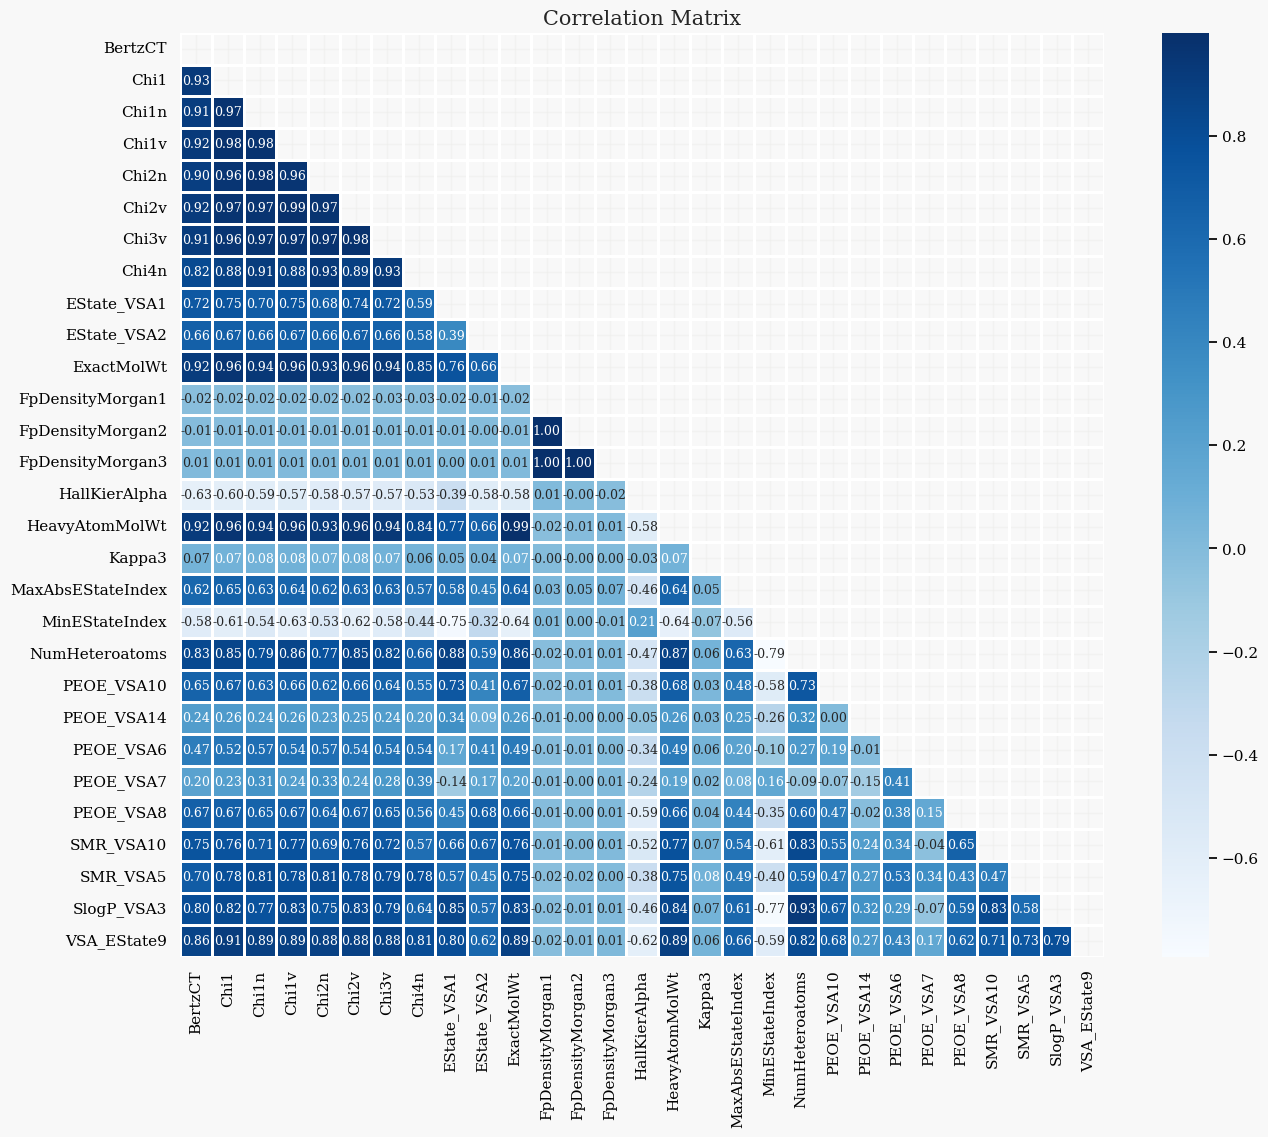

In [14]:
# Correlation

corr_matrix = train[num].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='Blues', fmt='.2f', linewidths=1, square=True, annot_kws={"size": 9} )
plt.title('Correlation Matrix', fontsize=15)
plt.show()


***Key point:***

***It is clear that many variables are highly correlated, the remarkable one being FpDensityMorgan1/2/3. Perhaps I should have kept just one of them.***

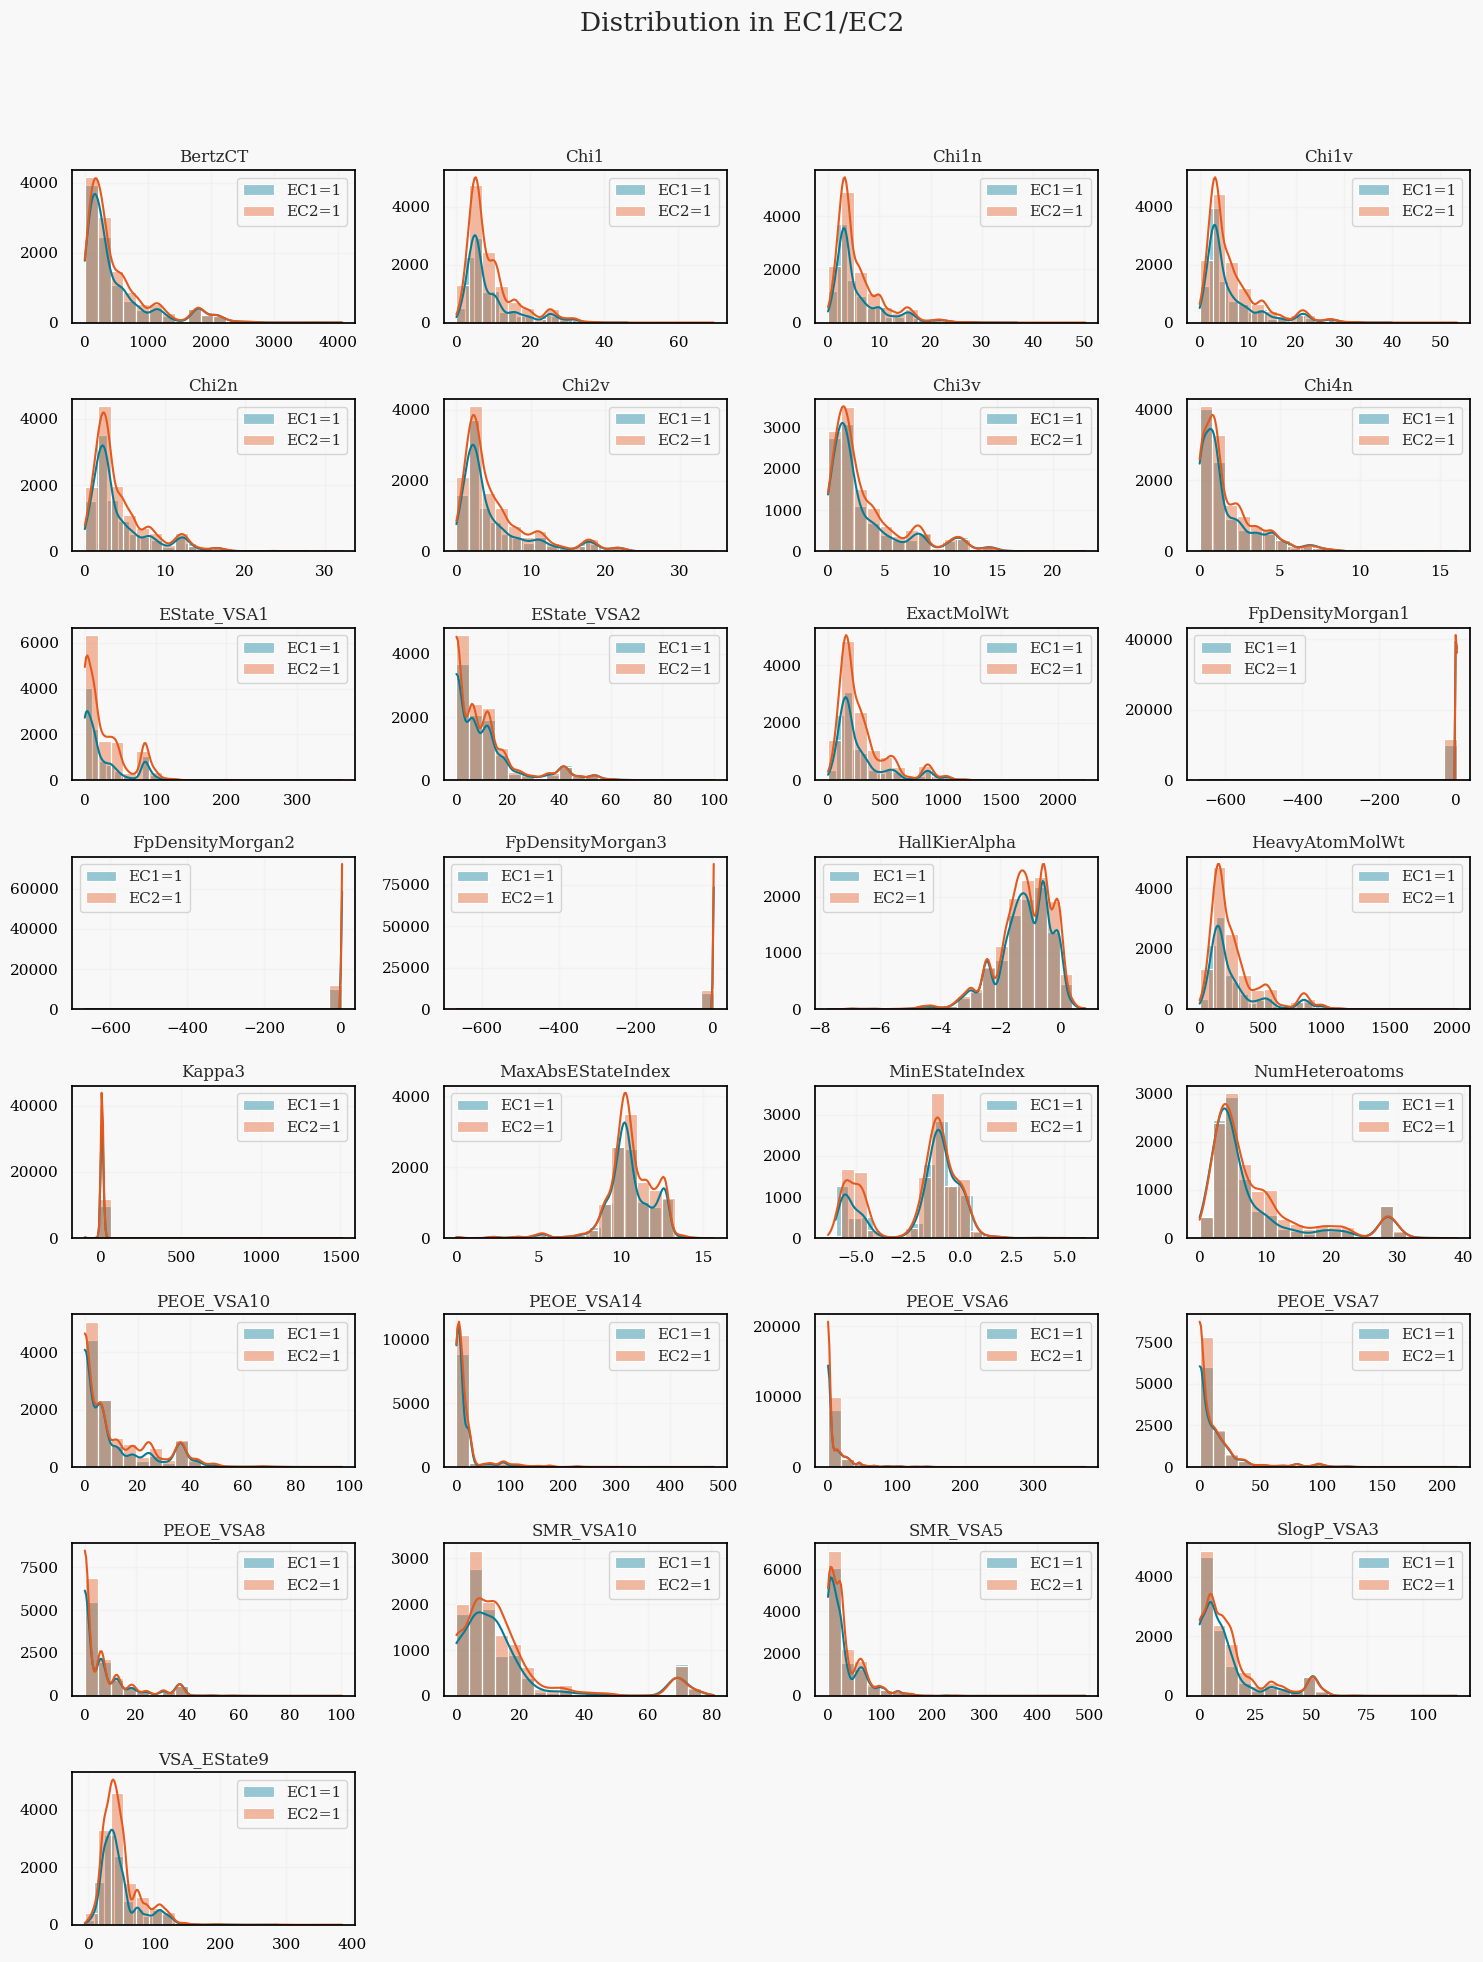

In [15]:
fig, axs = plt.subplots(8, 4, figsize=(15,20))
axs = axs.flatten()

for i, col in enumerate(num):
    ax = axs[i]
    sns.histplot(train[train['EC1']==1][col], ax=ax, bins=20, label="EC1=1", color=palette[1], alpha=0.4, kde=True)
    sns.histplot(train[train['EC2']==1][col], ax=ax, bins=20, label="EC2=1", color=palette[2], alpha=0.4, kde=True)

    ax.set_title(col, fontsize=12)
    ax.set_xlabel(None, fontsize=12)  
    ax.set_ylabel(None, fontsize=12)
    ax.legend()

for j in range(len(num), len(axs)):
    fig.delaxes(axs[j])

sns.set_palette(color_palette)
plt.tight_layout()
plt.suptitle('Distribution in EC1/EC2', fontsize=19)
plt.subplots_adjust(top=0.9, hspace=0.5)
plt.show()

***Key point***

***The distribution in EC1/EC2 look similar.***

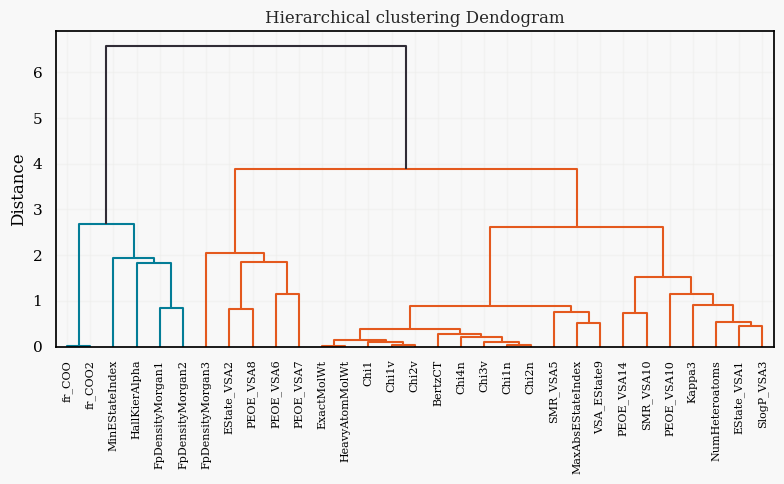

In [16]:
# hierarchical clustering
from scipy.cluster import hierarchy

spearman_corr = train.iloc[:,:-2].corr(method='spearman')
linkage_matrix = hierarchy.linkage(spearman_corr,method='complete')

fig,ax = plt.subplots(1,1,figsize=(8,5))
dendogram = hierarchy.dendrogram(linkage_matrix,ax=ax,labels=spearman_corr.columns.tolist())
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
_ = ax.set_ylabel('Distance')
_ = ax.set_title('Hierarchical clustering Dendogram')
fig.tight_layout()

In [17]:
pd.crosstab(train['EC1'], train['EC2']).reset_index().style.background_gradient(cmap='Blues')

EC2,EC1,0,1
0,0,582,4348
1,1,2401,7507


# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#1871c9; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #000966">Data prepocessing</p>
***I am very cautious in feature engineering as I have little knowledge about it. This will be improved in subsequent versions.***

In [18]:
num = num.drop(['FpDensityMorgan2', 'FpDensityMorgan3', 'Chi1v', 'Chi1n', 'Chi2n', 'Chi2v', 'Chi3v', 'Chi4n'])
num

Index(['BertzCT', 'Chi1', 'EState_VSA1', 'EState_VSA2', 'ExactMolWt',
       'FpDensityMorgan1', 'HallKierAlpha', 'HeavyAtomMolWt', 'Kappa3',
       'MaxAbsEStateIndex', 'MinEStateIndex', 'NumHeteroatoms', 'PEOE_VSA10',
       'PEOE_VSA14', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'SMR_VSA10',
       'SMR_VSA5', 'SlogP_VSA3', 'VSA_EState9'],
      dtype='object')

In [19]:
def data_preprocessing(df):
    # drop useless data
    df.drop(['FpDensityMorgan2', 'FpDensityMorgan3', 'Chi1v', 'Chi1n', 'Chi2n', 'Chi2v', 'Chi3v', 'Chi4n'],axis=1,inplace=True)    

    # scaling
    scaler = StandardScaler()
    scaler.fit(df[num])
    df[num] = scaler.transform(df[num])
    df[num] = scaler.transform(df[num])
    return df


In [20]:
train = data_preprocessing(train)
test = data_preprocessing(test)

# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#1871c9; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #000966">Features Selection</p>

In [21]:
X_ec1 = train.drop(['EC2'],axis=1)
X_ec2 = train.drop(['EC1'],axis=1)

In [22]:
'''def feature_selection(X,y,clf):
    rfecv = RFECV(clf)
    rfecv.fit(X,y)
    print("Optimal number of features : %d" % rfecv.n_features_)
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
'''

'def feature_selection(X,y,clf):\n    rfecv = RFECV(clf)\n    rfecv.fit(X,y)\n    print("Optimal number of features : %d" % rfecv.n_features_)\n    plt.figure()\n    plt.xlabel("Number of features selected")\n    plt.ylabel("Cross validation score (nb of correct classifications)")\n    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)\n    plt.show()\n'

In [23]:
'''# Feature selection for task EC1

feature_selection(X_ec1.drop('EC1',axis=1), X_ec1['EC1'], RandomForestClassifier())'''

"# Feature selection for task EC1\n\nfeature_selection(X_ec1.drop('EC1',axis=1), X_ec1['EC1'], RandomForestClassifier())"

In [24]:
# Feature selection for task EC2

# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#1871c9; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #000966">Baseline models</p>

## <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#1871c9; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #000966">Baseline models for EC1</p>

In [25]:
baseline_models = {
    'xgb':XGBClassifier(),
    'lgbm':LGBMClassifier(),
    'catboost':CatBoostClassifier(),
    'rf':RandomForestClassifier()
}

X_train, X_test, y_train, y_test = train_test_split(X_ec1, train['EC1'], test_size=0.2, random_state=42)

for model_name,model in baseline_models.items():
    print(f'Training baseline model {model_name}')
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    roc_auc = roc_auc_score(y_test, y_pred)
    print(f'Baseline model with ROC AUC: {roc_auc}')
    print(classification_report(y_test, y_pred))

    

Training baseline model xgb
Baseline model with ROC AUC: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       976
           1       1.00      1.00      1.00      1992

    accuracy                           1.00      2968
   macro avg       1.00      1.00      1.00      2968
weighted avg       1.00      1.00      1.00      2968

Training baseline model lgbm
Baseline model with ROC AUC: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       976
           1       1.00      1.00      1.00      1992

    accuracy                           1.00      2968
   macro avg       1.00      1.00      1.00      2968
weighted avg       1.00      1.00      1.00      2968

Training baseline model catboost
Learning rate set to 0.02963
0:	learn: 0.5845190	total: 65.8ms	remaining: 1m 5s
1:	learn: 0.4914161	total: 73.1ms	remaining: 36.5s
2:	learn: 0.4133102	total: 79.8ms	remaining: 26.5s
3:	learn

## <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#1871c9; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #000966">Baseline models for EC2</p>

In [26]:
baseline_models = {
    'xgb':XGBClassifier(),
    'lgbm':LGBMClassifier(),
    'catboost':CatBoostClassifier(),
    'rf':RandomForestClassifier()
}

X_train, X_test, y_train, y_test = train_test_split(X_ec2, train['EC2'], test_size=0.2, random_state=42)

for model_name,model in baseline_models.items():
    print(f'Training baseline model {model_name}')
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    roc_auc = roc_auc_score(y_test, y_pred)
    print(f'Baseline model with ROC AUC: {roc_auc}')
    print(classification_report(y_test, y_pred))

Training baseline model xgb
Baseline model with ROC AUC: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       568
           1       1.00      1.00      1.00      2400

    accuracy                           1.00      2968
   macro avg       1.00      1.00      1.00      2968
weighted avg       1.00      1.00      1.00      2968

Training baseline model lgbm
Baseline model with ROC AUC: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       568
           1       1.00      1.00      1.00      2400

    accuracy                           1.00      2968
   macro avg       1.00      1.00      1.00      2968
weighted avg       1.00      1.00      1.00      2968

Training baseline model catboost
Learning rate set to 0.02963
0:	learn: 0.5835827	total: 10.1ms	remaining: 10.1s
1:	learn: 0.4897101	total: 17.7ms	remaining: 8.84s
2:	learn: 0.4110327	total: 25ms	remaining: 8.32s
3:	learn: 

# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#1871c9; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #000966">Training weak classifiers</p>

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

def f_importance_plot(f_imp,title):
    fig = plt.figure(figsize=(12, 0.20*len(f_imp)))
    plt.title(f'Feature importances {title}', size=16, y=1.05, 
              fontweight='bold')
    a = sns.barplot(data=f_imp, x='avg_imp', y='feature', linestyle="-", 
                    linewidth=0.5, edgecolor="black",palette='pastel')
    plt.xlabel('')
    plt.xticks([])
    plt.ylabel('')
    plt.yticks(size=11)
    
    for j in ['right', 'top', 'bottom']:
        a.spines[j].set_visible(False)
    for j in ['left']:
        a.spines[j].set_linewidth(0.5)
    plt.tight_layout()
    plt.show()
    
def show_confusion_roc(preds, target, title):   
    f, ax = plt.subplots(1, 2, figsize=(13.3, 4))
    df = pd.DataFrame({'preds': preds, 'target': target})
    cm = confusion_matrix(df.target, df.preds.ge(0.5).astype(int))
    cm_display = ConfusionMatrixDisplay(cm).plot(cmap = 'Blues',ax=ax[0])
    ax[0].grid(False)
    RocCurveDisplay.from_predictions(df.target, df.preds,  ax=ax[1])
    plt.suptitle(f'Confusion_ROC {title}', fontsize=16, fontweight='bold', y=1.05)
    plt.tight_layout()

    
def get_mean_auc(oof, target):
    mean_val_auc = roc_auc_score(train[target], oof)
    return mean_val_auc

In [28]:
feature = num.tolist() + cat.tolist()

## <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#1871c9; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #000966">Predict EC1</p>

In [29]:
models_ec1 = {}

X = train.drop(target, axis=1)
y = train['EC1']

aml_lgb_cv_scores_EC1, aml_lgb_preds_EC1 = list(), list()
aml_rf_cv_scores_EC1, aml_rf_preds_EC1 = list(), list()
aml_cat_cv_scores_EC1, aml_cat_preds_EC1 = list(), list()

ens_cv_scores_EC1, ens_preds_EC1 = list(), list()

skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)

for i, (train_ix, test_ix) in enumerate(skf.split(X, y)):
        
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    Y_train, Y_test = y.iloc[train_ix], y.iloc[test_ix]
    
    print('---------------------------------------------------------------')
    
    ##################
    ## FLAML (LGBM) ##
    ##################
    
    automl_lgbm = AutoML()
    
    automl_settings = {'time_budget': 120,  
                       'metric': 'roc_auc',
                       'task': 'classification',
                       'estimator_list': ['lgbm'],
                       "log_file_name": '',
                      }

    automl_lgbm.fit(X_train = X_train, y_train = Y_train, **automl_settings, verbose = False)
    
    aml_lgb_pred_1 = automl_lgbm.predict_proba(X_test)[:, 1]
    aml_lgb_pred_2 = automl_lgbm.predict_proba(test)[:, 1]

    aml_lgb_score_fold = roc_auc_score(Y_test, aml_lgb_pred_1)
    aml_lgb_cv_scores_EC1.append(aml_lgb_score_fold)
    aml_lgb_preds_EC1.append(aml_lgb_pred_2)
    
    models_ec1['LGBM'] = {'model': automl_lgbm.model, 'best_params': automl_lgbm.best_config}
    
    print('Fold', i, '==> FLAML (LGBM) oof ROC-AUC is ==>', aml_lgb_score_fold)

    ###########################
    ## FLAML (Random Forest) ##
    ###########################
    
    automl_rf = AutoML()
    
    automl_settings = {'time_budget': 120,  
                       'metric': 'roc_auc',
                       'task': 'classification',
                       'estimator_list': ['rf'],
                       "log_file_name": '',
                      }

    automl_rf.fit(X_train = X_train, y_train = Y_train, **automl_settings, verbose = False)
    
    aml_rf_pred_1 = automl_rf.predict_proba(X_test)[:, 1]
    aml_rf_pred_2 = automl_rf.predict_proba(test)[:, 1]

    aml_rf_score_fold = roc_auc_score(Y_test, aml_rf_pred_1)
    aml_rf_cv_scores_EC1.append(aml_rf_score_fold)
    aml_rf_preds_EC1.append(aml_rf_pred_2)
    
    models_ec1['RandomForest'] = {'model': automl_rf.model, 'best_params': automl_rf.best_config}
    
    print('Fold', i, '==> FLAML (RF) oof ROC-AUC is ==>', aml_rf_score_fold)

    ######################
    ## FLAML (CatBoost) ##
    ######################
    
    automl_cat = AutoML()
    
    automl_settings = {'time_budget': 120,  
                       'metric': 'roc_auc',
                       'task': 'classification',
                       'estimator_list': ['catboost'],
                       "log_file_name": '',
                      }

    automl_cat.fit(X_train = X_train, y_train = Y_train, **automl_settings, verbose = False)
    
    aml_cat_pred_1 = automl_cat.predict_proba(X_test)[:, 1]
    aml_cat_pred_2 = automl_cat.predict_proba(test)[:, 1]

    aml_cat_score_fold = roc_auc_score(Y_test, aml_cat_pred_1)
    aml_cat_cv_scores_EC1.append(aml_cat_score_fold)
    aml_cat_preds_EC1.append(aml_cat_pred_2)
    
    models_ec1['Catboost'] = {'model': automl_cat.model, 'best_params': automl_cat.best_config}
    
    print('Fold', i, '==> FLAML (CatBoost) oof ROC-AUC is ==>', aml_cat_score_fold)
    
    ######################
    ## Average Ensemble ##
    ######################
    
    ens_pred_1 = (aml_lgb_pred_1 + aml_rf_pred_1 + aml_cat_pred_1 ) / 3
    ens_pred_2 = (aml_lgb_pred_2 + aml_rf_pred_2 + aml_cat_pred_2 ) / 3
    
    ens_score_fold = roc_auc_score(Y_test, ens_pred_1)
    ens_cv_scores_EC1.append(ens_score_fold)
    ens_preds_EC1.append(ens_pred_2)
    
    print('Fold', i, '==> Average Ensemble oof ROC-AUC score is ==>', ens_score_fold)

---------------------------------------------------------------
Fold 0 ==> FLAML (LGBM) oof ROC-AUC is ==> 0.7028438502301648
Fold 0 ==> FLAML (RF) oof ROC-AUC is ==> 0.7030157830208182
Fold 0 ==> FLAML (CatBoost) oof ROC-AUC is ==> 0.7008980929787971
Fold 0 ==> Average Ensemble oof ROC-AUC score is ==> 0.7034916684235195
---------------------------------------------------------------
Fold 1 ==> FLAML (LGBM) oof ROC-AUC is ==> 0.6971782554143479
Fold 1 ==> FLAML (RF) oof ROC-AUC is ==> 0.6938718752750413
Fold 1 ==> FLAML (CatBoost) oof ROC-AUC is ==> 0.7001448636102201
Fold 1 ==> Average Ensemble oof ROC-AUC score is ==> 0.6984792647007653
---------------------------------------------------------------
Fold 2 ==> FLAML (LGBM) oof ROC-AUC is ==> 0.715392129571826
Fold 2 ==> FLAML (RF) oof ROC-AUC is ==> 0.7163835574941205
Fold 2 ==> FLAML (CatBoost) oof ROC-AUC is ==> 0.710902688087309
Fold 2 ==> Average Ensemble oof ROC-AUC score is ==> 0.7157101540640615
------------------------------

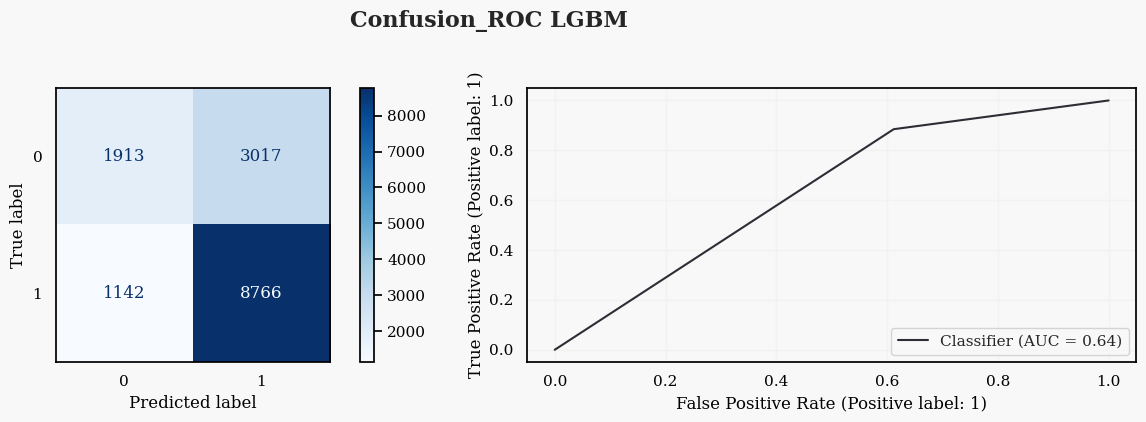

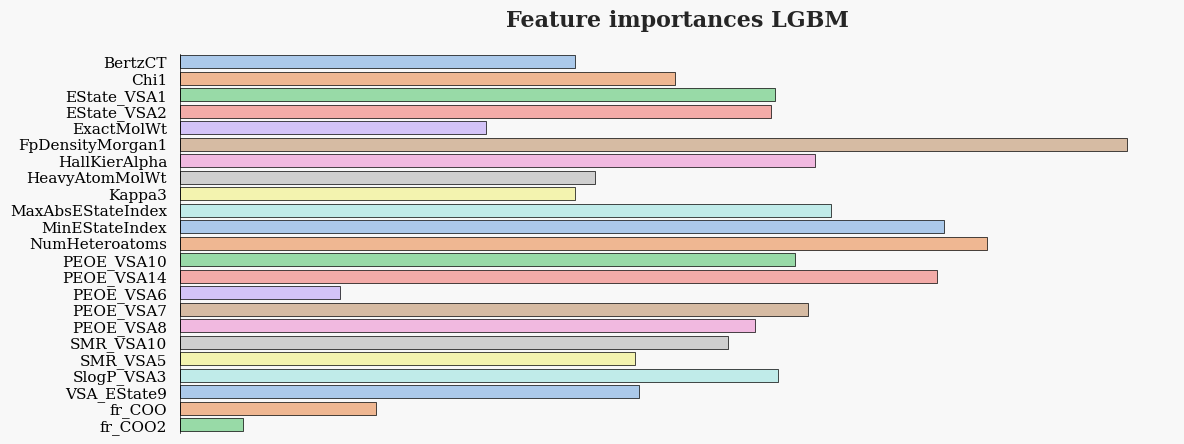

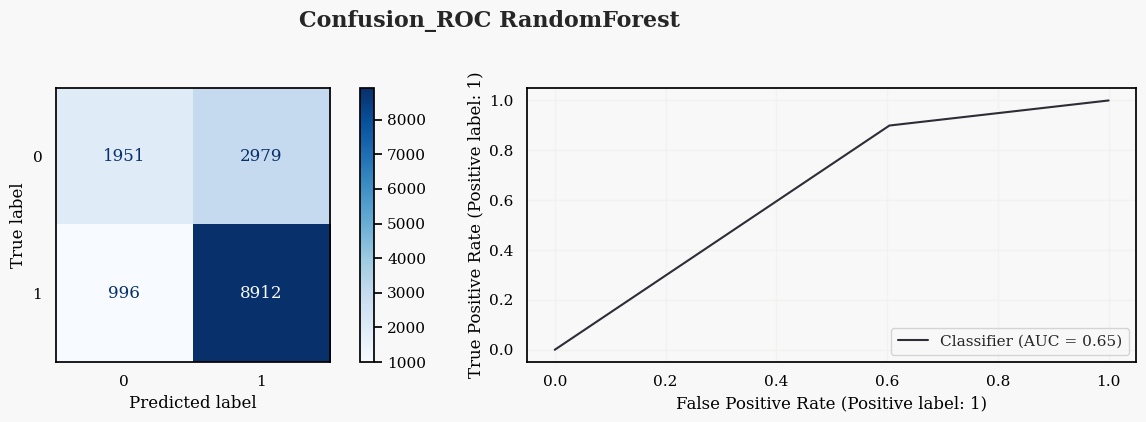

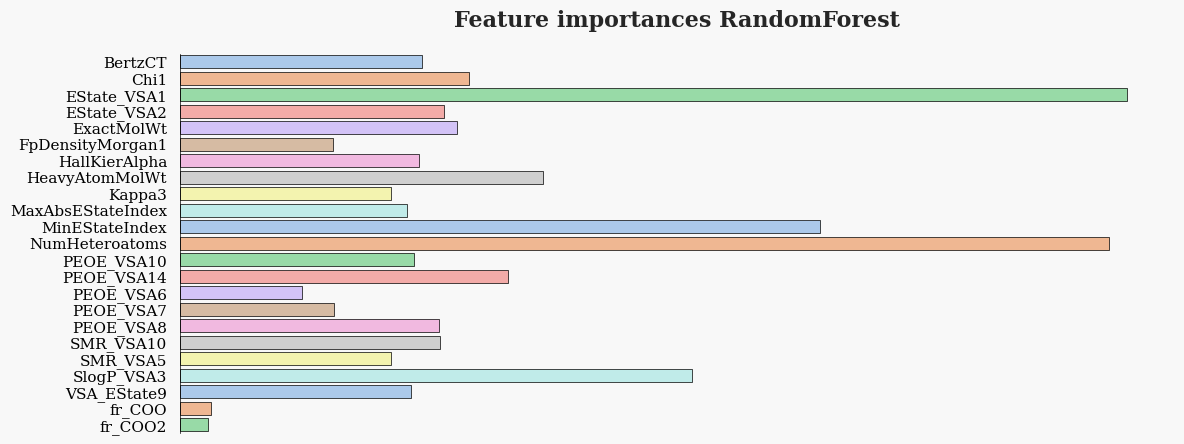

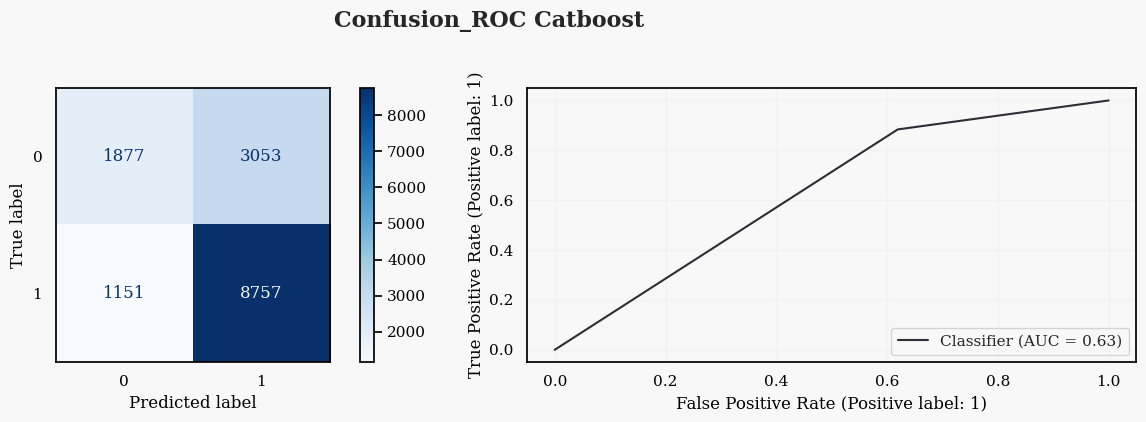

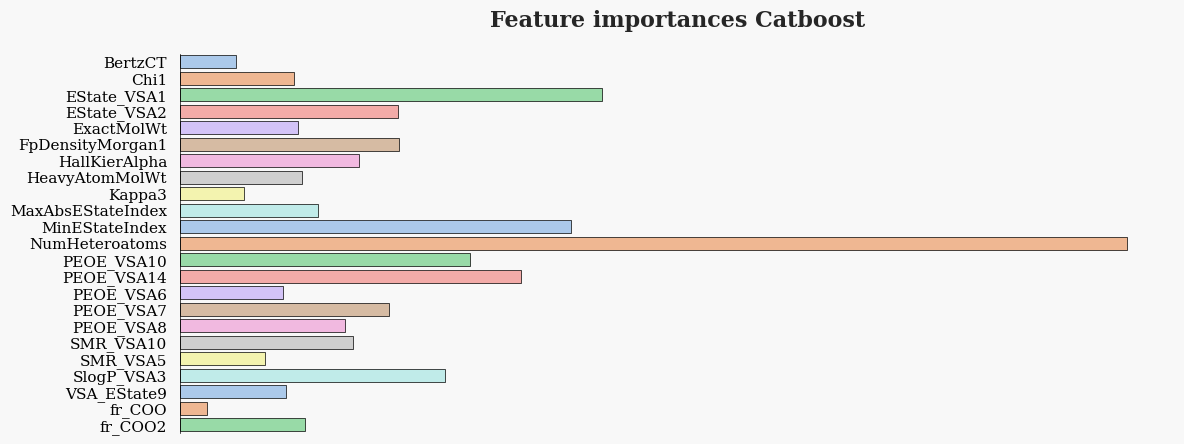

In [30]:
ensemble_pred = []
ensemble_scores = []

for model_name, model_info in models_ec1.items():
    model = model_info['model']
    pred = model.predict(X)
    ensemble_pred.append(pred)
    
    show_confusion_roc(pred, train['EC1'],model_name)
    f_imp_df = pd.DataFrame({'feature': feature, 'avg_imp': model.feature_importances_})
    f_importance_plot(f_imp_df,model_name)

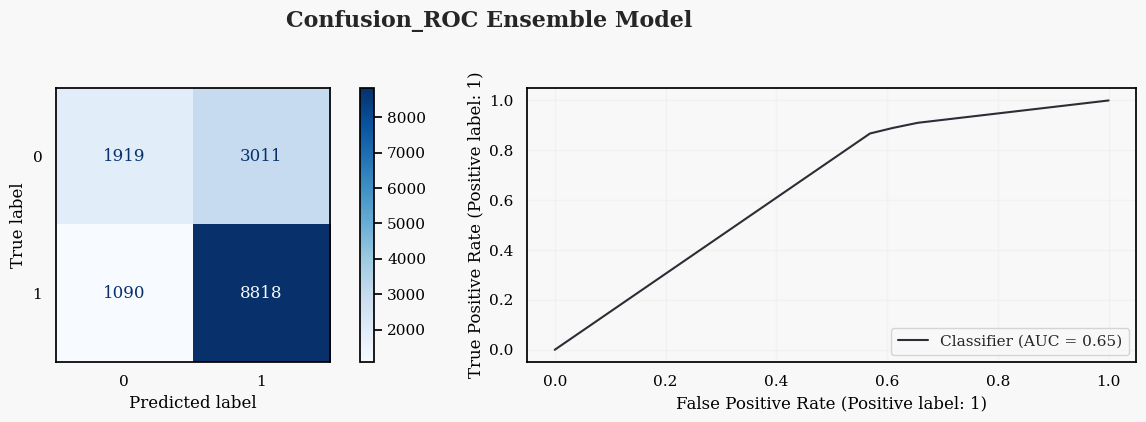

In [31]:
ensemble_pred_ec1 = np.mean(ensemble_pred, axis=0)
show_confusion_roc(ensemble_pred_ec1, train['EC1'],'Ensemble Model')

***Let's take a look at those models***

In [32]:
models_ec1

{'LGBM': {'model': <flaml.automl.model.LGBMEstimator at 0x7adda8650250>,
  'best_params': {'n_estimators': 403,
   'num_leaves': 10,
   'min_child_samples': 19,
   'learning_rate': 0.01345570065693132,
   'log_max_bin': 7,
   'colsample_bytree': 0.6328886061130559,
   'reg_alpha': 0.0041713399212704,
   'reg_lambda': 2.6302186987671448}},
 'RandomForest': {'model': <flaml.automl.model.RandomForestEstimator at 0x7adda8651780>,
  'best_params': {'n_estimators': 48,
   'max_features': 0.1850748752501414,
   'max_leaves': 61,
   'criterion': 'entropy'}},
 'Catboost': {'model': <flaml.automl.model.CatBoostEstimator at 0x7addb8ce15a0>,
  'best_params': {'early_stopping_rounds': 24,
   'learning_rate': 0.03277353894797391,
   'n_estimators': 89}}}

## <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#1871c9; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #000966">Predict EC2</p>

In [33]:
models_ec2 = {}

y = train['EC2']

aml_lgb_cv_scores_EC2, aml_lgb_preds_EC2 = list(), list()
aml_rf_cv_scores_EC2, aml_rf_preds_EC2 = list(), list()
aml_cat_cv_scores_EC2, aml_cat_preds_EC2 = list(), list()

ens_cv_scores_EC2, ens_preds_EC2 = list(), list()

skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)

for i, (train_ix, test_ix) in enumerate(skf.split(X, y)):
        
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    Y_train, Y_test = y.iloc[train_ix], y.iloc[test_ix]
    
    print('---------------------------------------------------------------')
    
    ##################
    ## FLAML (LGBM) ##
    ##################
    
    automl_lgbm = AutoML()
    
    automl_settings = {'time_budget': 120,  
                       'metric': 'roc_auc',
                       'task': 'classification',
                       'estimator_list': ['lgbm'],
                       "log_file_name": '',
                      }

    automl_lgbm.fit(X_train = X_train, y_train = Y_train, **automl_settings, verbose = False)
    
    aml_lgb_pred_1 = automl_lgbm.predict_proba(X_test)[:, 1]
    aml_lgb_pred_2 = automl_lgbm.predict_proba(test)[:, 1]

    aml_lgb_score_fold = roc_auc_score(Y_test, aml_lgb_pred_1)
    aml_lgb_cv_scores_EC2.append(aml_lgb_score_fold)
    aml_lgb_preds_EC2.append(aml_lgb_pred_2)
 
    models_ec2['LGBM'] = {'model': automl_lgbm.model, 'best_params': automl_lgbm.best_config}
    
    print('Fold', i, '==> FLAML (LGBM) oof ROC-AUC is ==>', aml_lgb_score_fold)

    ###########################
    ## FLAML (Random Forest) ##
    ###########################
    
    automl_rf = AutoML()
    
    automl_settings = {'time_budget': 120,  
                       'metric': 'roc_auc',
                       'task': 'classification',
                       'estimator_list': ['rf'],
                       "log_file_name": '',
                      }

    automl_rf.fit(X_train = X_train, y_train = Y_train, **automl_settings, verbose = False)
    
    aml_rf_pred_1 = automl_rf.predict_proba(X_test)[:, 1]
    aml_rf_pred_2 = automl_rf.predict_proba(test)[:, 1]

    aml_rf_score_fold = roc_auc_score(Y_test, aml_rf_pred_1)
    aml_rf_cv_scores_EC2.append(aml_rf_score_fold)
    aml_rf_preds_EC2.append(aml_rf_pred_2)

    models_ec2['RandomForest'] = {'model': automl_rf.model, 'best_params': automl_rf.best_config}
    print('Fold', i, '==> FLAML (RF) oof ROC-AUC is ==>', aml_rf_score_fold)

    ######################
    ## FLAML (CatBoost) ##
    ######################
    
    automl_cat = AutoML()
    
    automl_settings = {'time_budget': 120,  
                       'metric': 'roc_auc',
                       'task': 'classification',
                       'estimator_list': ['catboost'],
                       "log_file_name": '',
                      }

    automl_cat.fit(X_train = X_train, y_train = Y_train, **automl_settings, verbose = False)
    
    aml_cat_pred_1 = automl_cat.predict_proba(X_test)[:, 1]
    aml_cat_pred_2 = automl_cat.predict_proba(test)[:, 1]

    aml_cat_score_fold = roc_auc_score(Y_test, aml_cat_pred_1)
    aml_cat_cv_scores_EC2.append(aml_cat_score_fold)
    aml_cat_preds_EC2.append(aml_cat_pred_2)
    
    models_ec2['CatBoost'] = {'model': automl_cat.model, 'best_params': automl_cat.best_config}
    print('Fold', i, '==> FLAML (CatBoost) oof ROC-AUC is ==>', aml_cat_score_fold)
    
    ######################
    ## Average Ensemble ##
    ######################
    
    ens_pred_1 = (aml_lgb_pred_1 + aml_rf_pred_1 + aml_cat_pred_1 ) / 3
    ens_pred_2 = (aml_lgb_pred_2 + aml_rf_pred_2 + aml_cat_pred_2 ) / 3
    
    ens_score_fold = roc_auc_score(Y_test, ens_pred_1)
    ens_cv_scores_EC2.append(ens_score_fold)
    ens_preds_EC2.append(ens_pred_2)
    
    print('Fold', i, '==> Average Ensemble oof ROC-AUC score is ==>', ens_score_fold)

---------------------------------------------------------------
Fold 0 ==> FLAML (LGBM) oof ROC-AUC is ==> 0.5770395630620415
Fold 0 ==> FLAML (RF) oof ROC-AUC is ==> 0.5759872750509188
Fold 0 ==> FLAML (CatBoost) oof ROC-AUC is ==> 0.5875550252315986
Fold 0 ==> Average Ensemble oof ROC-AUC score is ==> 0.5851791644854385
---------------------------------------------------------------
Fold 1 ==> FLAML (LGBM) oof ROC-AUC is ==> 0.5814069645288159
Fold 1 ==> FLAML (RF) oof ROC-AUC is ==> 0.580586398886037
Fold 1 ==> FLAML (CatBoost) oof ROC-AUC is ==> 0.5807019068348914
Fold 1 ==> Average Ensemble oof ROC-AUC score is ==> 0.5806030009459642
---------------------------------------------------------------
Fold 2 ==> FLAML (LGBM) oof ROC-AUC is ==> 0.5965632323009677
Fold 2 ==> FLAML (RF) oof ROC-AUC is ==> 0.6007285831660765
Fold 2 ==> FLAML (CatBoost) oof ROC-AUC is ==> 0.6081620671895962
Fold 2 ==> Average Ensemble oof ROC-AUC score is ==> 0.6049409143284256
-----------------------------

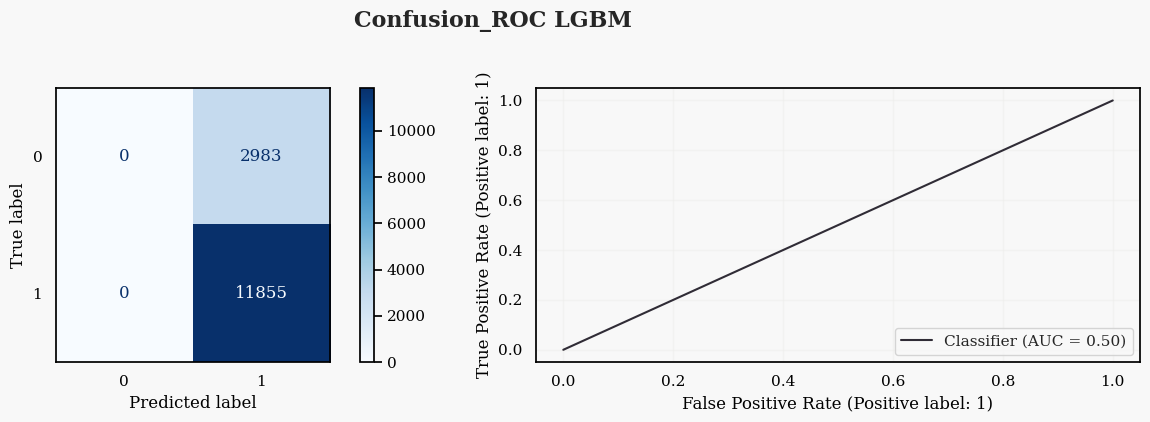

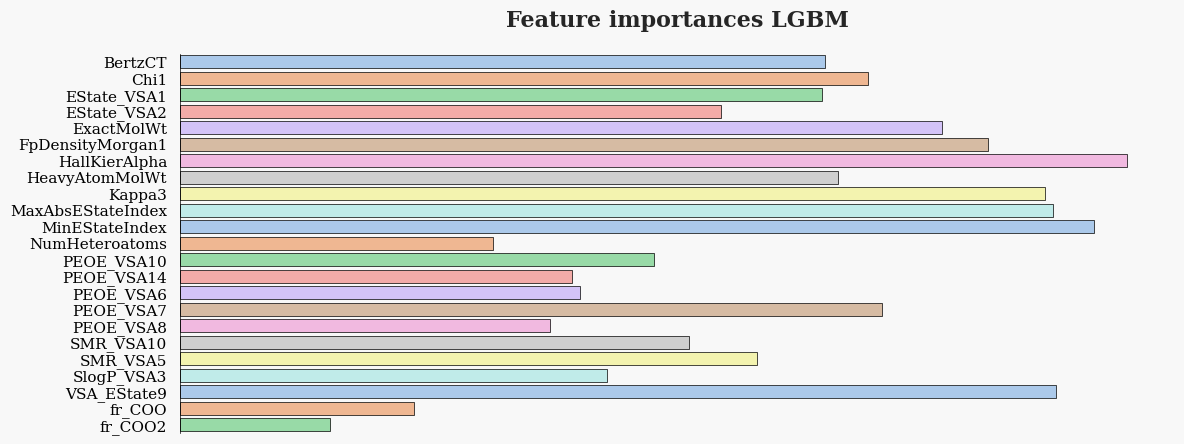

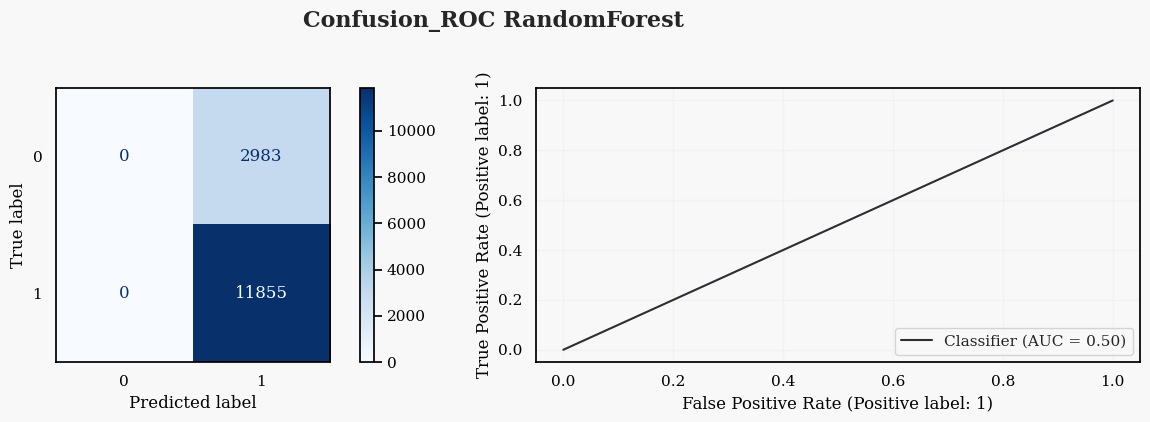

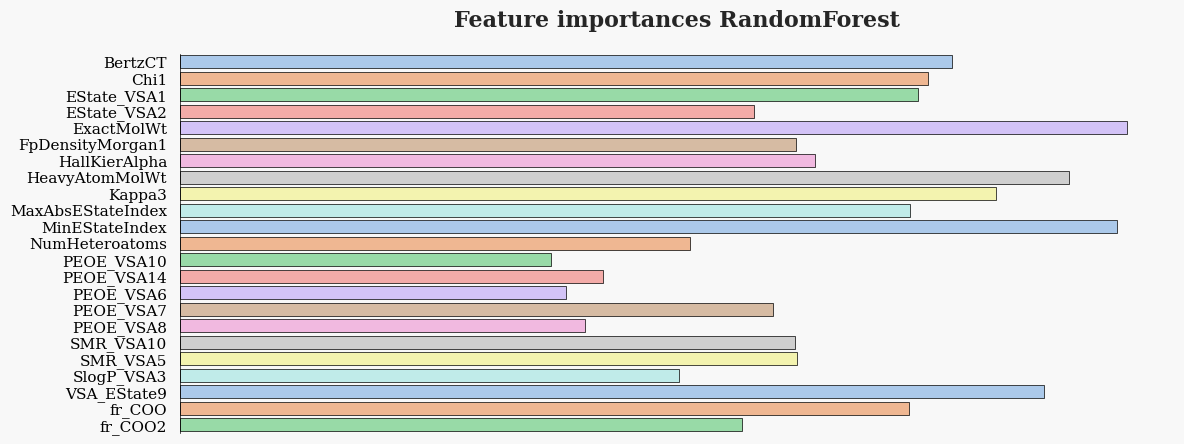

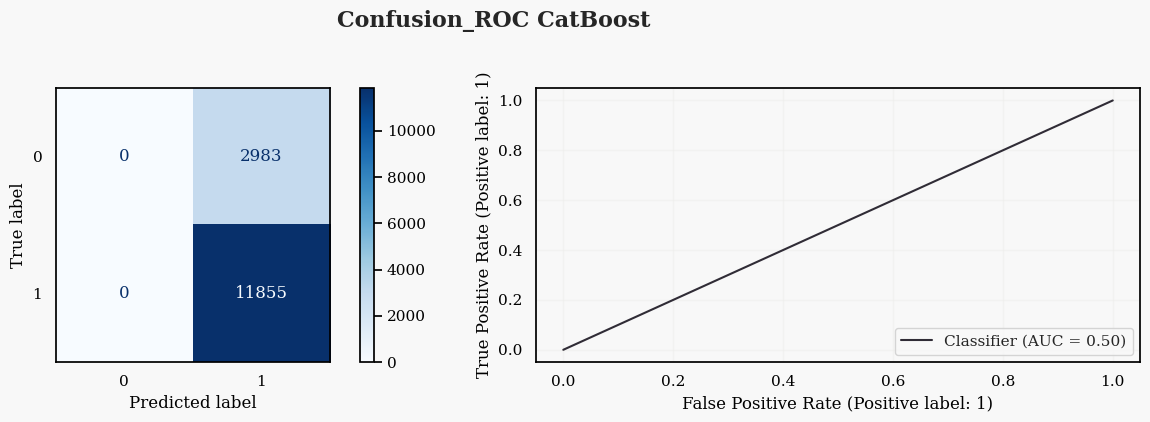

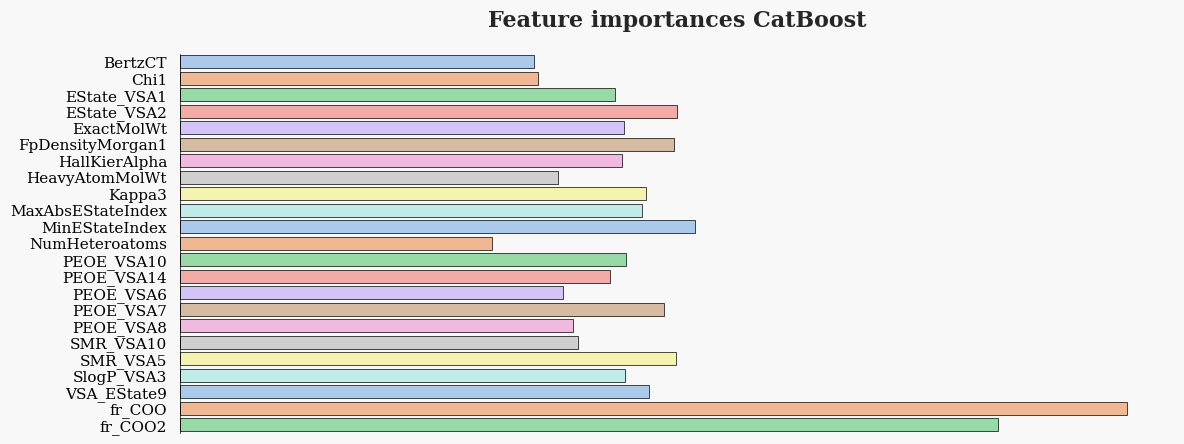

In [34]:
ensemble_pred = []
ensemble_scores = []

for model_name, model_info in models_ec2.items():
    model = model_info['model']
    pred = model.predict(X)
    ensemble_pred.append(pred)
    
    show_confusion_roc(pred, train['EC2'],model_name)
    f_imp_df = pd.DataFrame({'feature': feature, 'avg_imp': model.feature_importances_})
    f_importance_plot(f_imp_df,model_name)

In [35]:
models_ec2

{'LGBM': {'model': <flaml.automl.model.LGBMEstimator at 0x7addb8750eb0>,
  'best_params': {'n_estimators': 253,
   'num_leaves': 21,
   'min_child_samples': 33,
   'learning_rate': 0.01115434867466193,
   'log_max_bin': 7,
   'colsample_bytree': 0.3375847351769921,
   'reg_alpha': 0.0009765625,
   'reg_lambda': 0.027262471295458255}},
 'RandomForest': {'model': <flaml.automl.model.RandomForestEstimator at 0x7addabfd6c20>,
  'best_params': {'n_estimators': 61,
   'max_features': 0.1236290934016947,
   'max_leaves': 54,
   'criterion': 'entropy'}},
 'CatBoost': {'model': <flaml.automl.model.CatBoostEstimator at 0x7addabfd6320>,
  'best_params': {'early_stopping_rounds': 14,
   'learning_rate': 0.005,
   'n_estimators': 494}}}

In [36]:
ens_preds_test_EC1 = pd.DataFrame(ens_preds_EC1).apply(np.mean, axis = 0)
ens_preds_test_EC2 = pd.DataFrame(ens_preds_EC2).apply(np.mean, axis = 0)

sample['EC1'] = ens_preds_test_EC1
sample['EC2'] = ens_preds_test_EC2
sample.to_csv('FLAML_Ensemble_submission.csv', index = False)

***This version of the notebook still has very much to be improved. I have consulted many high scoring notebooks for model selection, and I am currently trying to optimize the baseline model using optuna on a private notebook, which will appear in the next version.***

### ***Hope this helps! Please upvote if you like it!***